In [1]:
#Importing
#Importing the libraries that will be used
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
from torch.utils.data import random_split


This Python 3 environment comes with many helpful analytics libraries installed

It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Input data files are available in the read-only "../input/" directory

For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"

You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import torchvision.transforms as tt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/chetankv/dogs-cats-images?select=dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rshubhangi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/chetankv/dogs-cats-images


100%|██████████| 435M/435M [00:23<00:00, 19.3MB/s]


In [5]:
#Exploring Intel Image Dataset
#Looking into the Data Folder
data_dir='./dogs-cats-images'

In [6]:
import os
os.listdir(data_dir)



['dog vs cat', 'dataset']

In [7]:
data_dir = './dogs-cats-images/dataset'
train_dir = data_dir + "/training_set"
test_dir = data_dir + "/test_set"

In [8]:
train_dir

'./dogs-cats-images/dataset/training_set'

In [9]:
classes = os.listdir(test_dir)
print(classes)

['cats', 'dogs']


In [10]:
cats = os.listdir(train_dir + "/cats")
print('No. of training examples for cats:', len(cats))
print(cats[:5])

No. of training examples for cats: 4000
['cat.698.jpg', 'cat.912.jpg', 'cat.3310.jpg', 'cat.1986.jpg', 'cat.3622.jpg']


In [11]:
dogs = os.listdir(train_dir + "/dogs")
print('No. of training examples for dogs:', len(cats))
print(dogs[:5])

No. of training examples for dogs: 4000
['dog.793.jpg', 'dog.167.jpg', 'dog.3290.jpg', 'dog.2320.jpg', 'dog.2754.jpg']


In [12]:
dogs = os.listdir(test_dir + "/dogs")
print('No. of training examples for dogs:', len(dogs))
print(dogs[:5])

No. of training examples for dogs: 1000
['dog.4562.jpg', 'dog.4038.jpg', 'dog.4763.jpg', 'dog.4098.jpg', 'dog.4538.jpg']


In [13]:
from types import ClassMethodDescriptorType
cats = os.listdir(test_dir + "/cats")
print('No. of testing examples for cats:', len(cats))


No. of testing examples for cats: 1000


The above directory structure (one folder per class) is used by many computer vision datasets, and most deep learning libraries provide utilites for working with such datasets. We can use the ImageFolder class from torchvision to load the data as PyTorch tensors.

Since the data consists of color images with 3 channels (RGB), each image tensor has the shape of varying size.So we are resizing the image to have same shape (50,50)

In [14]:
from torchvision.datasets import ImageFolder

In [15]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
dataset = ImageFolder(data_dir+'/training_set', transform=transform)
test_dataset = ImageFolder(data_dir+'/test_set', transform=transform)

In [16]:
img, label = dataset[0]
print(img.shape, label)
# img

torch.Size([3, 50, 50]) 0


As a internal functionality, the list of classes is stored in the .classes property of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [17]:
print(dataset.classes)

['cats', 'dogs']


We can view the image using matplotlib, but we need to change the tensor dimensions to (50,50,3). Notice, for matplotlib the channel should be specified in the third position. Let's create a helper function to display an image and its label.

In [18]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  cats (0)


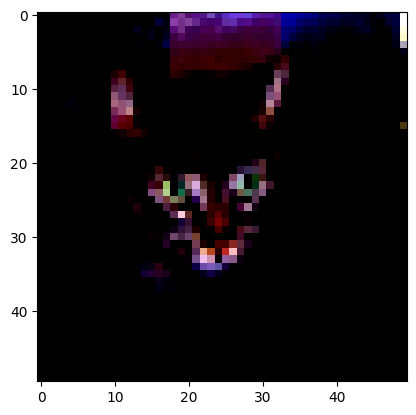

In [19]:
show_example(*dataset[0])

Label:  dogs (1)


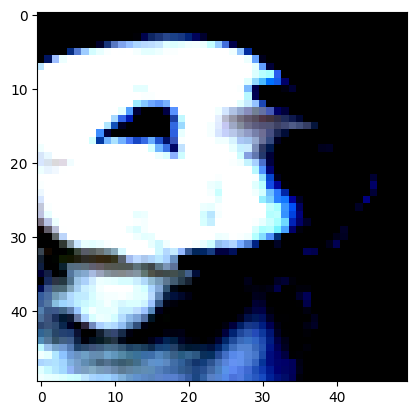

In [20]:
show_example(*dataset[4800])

Training and Validation Datasets¶
While building real world machine learning models, it is quite common to split the dataset into 3 parts:

Training set - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model. Since there's no predefined validation set, we can set aside a small portion of the training set to be used as the validation set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator

In [21]:
# random_seed = 42
# torch.manual_seed(random_seed);

In [22]:
len(dataset)

8000

In [23]:
len(test_dataset)

2000

In [24]:
val_size = 2000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6000, 2000)

DataLoader¶
We can now created data loaders to help us load the data in batches. Large datasets requires loading them into memory all at once. This leads to memory outage and slowing down of programs. PyTorch offers a solution for parallelizing the data loading process with the support of automatic batching as well. This is the DataLoader class present within the torch.utils.data package.

We'll use a batch size of 64, we will load 64 samples at a time until all the 50000 images in the training set are loaded and trained to complete 1 epoch.

What is batch size?
The number of samples (data points) that would be passed through the network at a time.

What is epoch?
An epoch is one single pass of all the input data through the network.

Relation between batch_size and epoch?
batch_size is not equal to epoch, consider you have 1000 images. Processing all the 1000 images through the network once is considered as 1 epoch. If we set the batch size as 10, during training we will be passing 100 data points (=1000/10) at a time until we eventually pass in all the training data to complete 1 single epoch.

Generally, larger the batch size faster the training. However, you need to have enough hardware to handle. Sometimes, even if our machine can handle heavy computation,by setting larger batch size quality of the model could degrade and could create difficulty in generalizing.

In [25]:
batch_size=64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [26]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

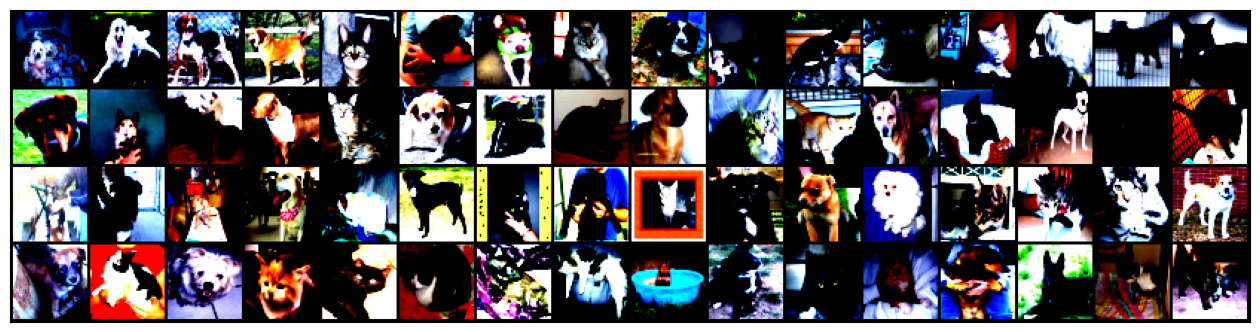

In [27]:
show_batch(train_loader)

Evaluation Metric and Loss Function
Let's first define out evaluation metric, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the prediction

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Here we are using torch.max() function, this function's default behaviour as you can guess by the name is to return maximum among the elements in the Tensor. However, this function also helps get the maximum along a particular dimension, as a Tensor, instead of a single element. To specify the dimension (axis – in numpy), there is another optional keyword argument, called dim. This represents the direction that we take for the maximum.

max_elements, max_indices = torch.max(input_tensor, dim)

dim=0, (maximum along columns).
dim=1 (maximum along rows).
This returns a tuple, max_elements and max_indices.

max_elements -> All the maximum elements of the Tensor.
max_indices -> Indices corresponding to the maximum elements.
In the above accuracy function, the == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Loss Function
While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. So we will be using Negative Log Loss function to compute the loss.

In [29]:
# Import necessary modules
import torch


dataiter = iter(train_loader)
images, labels = next(dataiter)


conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, stride=1)
conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
conv4 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1)
pool = nn.MaxPool2d(kernel_size=2)

print(f'origin shape: {images.shape}')
x = conv1(images)
print(f'conv1: {x.shape}')
x = pool(x)
print(f'pool1: {x.shape}')
x = conv2(x)
print(f'conv2: {x.shape}')
x = pool(x)
print(f'pool2: {x.shape}')
x = conv3(x)
print(f'conv3: {x.shape}')
x = pool(x)
print(f'pool3: {x.shape}')
x = conv4(x)
print(f'conv4: {x.shape}')
x = pool(x)
print(f'pool4: {x.shape}')
x = x.view(x.size(0), -1)
print(x.shape)



origin shape: torch.Size([64, 3, 50, 50])
conv1: torch.Size([64, 128, 50, 50])
pool1: torch.Size([64, 128, 25, 25])
conv2: torch.Size([64, 256, 25, 25])
pool2: torch.Size([64, 256, 12, 12])
conv3: torch.Size([64, 512, 12, 12])
pool3: torch.Size([64, 512, 6, 6])
conv4: torch.Size([64, 256, 6, 6])
pool4: torch.Size([64, 256, 3, 3])
torch.Size([64, 2304])


In [30]:
class CNN(nn.Module):
  def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=2)

        self.dropout = nn.Dropout(0.25)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [31]:
# Import the torch module
import torch

# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
device

device(type='cuda', index=0)

In [33]:
!pip install tqdm

In [34]:
from tqdm.auto import tqdm


In [37]:
# Create an instance of the model
# model = CNN()
#Model training
def fit(epochs, model, criterion, optimizer, device=device, dataloader=train_loader):

    i=0
    for e in enumerate(tqdm(range(epochs))):
        i = i+1
        running_loss = 0
        for images, labels in tqdm(dataloader):

            optimizer.zero_grad() # derivative gradient is zero for backward pass
            output = model(images) # forward pass to generate output
            loss = criterion(output, labels) # calculate the loss,predited output with actual output (ground truth)
            loss.backward() # calculate new derive for all weights
            optimizer.step() # updates the weight based on the derviative and learinging rate
            running_loss =  running_loss + loss.data
        else:
            print(f" Epoch {e}, Training loss: {running_loss/len(dataloader)}")
        torch.save(model.state_dict(), "./"+ str(i) +".pt")

In [38]:
import torch.optim as optim

epochs = 10
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

fit(epochs, model, criterion, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (0, 0), Training loss: 0.6881970167160034


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (1, 1), Training loss: 0.6607416272163391


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (2, 2), Training loss: 0.6312382221221924


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (3, 3), Training loss: 0.59308260679245


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (4, 4), Training loss: 0.5680817365646362


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (5, 5), Training loss: 0.5322635173797607


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (6, 6), Training loss: 0.5012485980987549


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (7, 7), Training loss: 0.45879071950912476


  0%|          | 0/94 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af5073cf7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af5073cf7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

 Epoch (8, 8), Training loss: 0.4352593421936035


  0%|          | 0/94 [00:00<?, ?it/s]

 Epoch (9, 9), Training loss: 0.37959006428718567


In [39]:
torch.save(model.state_dict(), "./cat_dog_model.pt") # save model parameters in the file


In [40]:
def predict(model, batch_size=25, device=device, dataloader=val_loader):
    classes = ('cats', 'dogs')
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(6)]
        n_class_samples = [0 for i in range(6)]
        for images, labels in tqdm(val_loader):
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            n_samples = n_samples + labels.size(0)
            n_correct =  n_correct + (predicted == labels).sum().item()

            # for i in range(batch_size):
            #     label = labels[i]
            #     pred = predicted[i]
            #     if (label == pred):
            #         n_class_correct[label] += 1
            #     n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {acc} %')

        # for i in range(6):
        #     acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        #     print(f'Accuracy of {classes[i]}: {acc} %')

In [41]:
predict(model)

  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy of the network: 73.7 %


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(data)  # Forward pass
        loss = criterion(outputs, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        train_loss += loss.item() * data.size(0)  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / total

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
